Тема: Mde и sample size

Видео лекции:  
https://www.youtube.com/watch?v=n-l1pkrUHdw
    
Видео семинара:  
https://www.youtube.com/watch?v=METU1NUcnL0

# Повторяю семинар №3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from ipywidgets import widgets

In [2]:
# Оформление графиков
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16

## Размер выборки

Основая формула для расчета размера выборки:

<font size=5>
$
n > \frac{[\Phi^{-1}(1 - \alpha) + \Phi^{-1}(1 - \beta)]^{2}(\sigma^{2}_{x} + \sigma^{2}_{y})}{\varepsilon^{2}}
$
</font>  

где:  
$n$ - число наблюдений   
$\varepsilon$ - размер эффекта   
$\alpha, \beta$ - размеры ошибок первого и второго рода   
$\sigma^{2}_{x}, \sigma^{2}_{y}$ - дисперсии первой и второй выборок   

Если зафиксируем $n$, то можно убрать его их формулы. Также предположим, что дисперсии обоих выборок равны. В итоге получим:

<font size=3>
$\frac{\varepsilon}{\sigma} = \Phi^{-1}(1 - \alpha) + \Phi^{-1}(1 - \beta)$   
    
$\Phi^{-1}(1 - \beta) = \frac{\varepsilon}{\sigma} - \Phi^{-1}(1 - \alpha)$
    
$1 - \beta = \Phi(\frac{\varepsilon}{\sigma} - \Phi^{-1}(1 - \alpha))$
    
$\beta = 1 - \Phi(\frac{\varepsilon}{\sigma} - \Phi^{-1}(1 - \alpha))$
</font>

In [3]:
# Вариант, если СКО у обоих выборок одинаковое
def get_beta(alpha, pilot_effect, pilot_std, two_side=False):
    """
    Расчет беты по формуле
    """
    if two_side:
        alpha = alpha / 2
    # z-значение, соответствуеющее альфе
    right_bound = stats.norm.ppf(1 - alpha)
    beta = 1 - stats.norm.cdf(pilot_effect / pilot_std - right_bound)
    if two_side:
        # Уменьшаю бета на толщину хвоста, который расположен
        # левее ЛЕВОЙ границы исходного (контрольного) распределения
        beta = beta - stats.norm.cdf(-pilot_effect / pilot_std - right_bound)
    
    return beta    

In [4]:
# Вроде рабочий вариант, если СКО двух выборок разные
# Не удается вывести правильную формулу для этого случая
def get_beta_std_not_equal(alpha, pilot_effect, pilot_std, control_std, two_side=False):
    if two_side:
        alpha = alpha / 2
    # z-значение, соответствуеющее альфе
    right_bound = stats.norm.ppf(1 - alpha)
    beta = 1 - stats.norm.cdf((pilot_effect - right_bound) * control_std / pilot_std)
    if two_side:
        # Уменьшаю бета на толщину хвоста, который расположен
        # левее ЛЕВОЙ границы исходного (контрольного) распределения
        beta = beta - stats.norm.cdf((-pilot_effect - right_bound) * control_std / pilot_std)
    
    return beta    

In [5]:
x = np.linspace(-4, 6, 1001)
H0_mean = 0
H0_std = 1
H0_dist = stats.norm(loc=H0_mean, scale=H0_std)
H0_pdf = H0_dist.pdf(x)

def plot_first_second_type_errors(alpha, pilot_effect, pilot_std, two_side=False):
    H1_dist = stats.norm(loc=pilot_effect, scale=pilot_std)
    H1_pdf = H1_dist.pdf(x)
    plt.figure(figsize=(10, 5))
    plt.plot(x, H0_pdf, label='Contol distribution')
    plt.plot(x, H1_pdf, label='Pilot distribution')
    
    alpha_adj = alpha / 2 if two_side else alpha
    left_tail = np.linspace(-4, H0_dist.ppf(alpha_adj), 101)
    right_tail = np.linspace(H0_dist.ppf(1 - alpha_adj), 6, 101)
    plt.fill_between(right_tail, H0_dist.pdf(right_tail), color='r', alpha=0.25)
    plt.fill_between(right_tail, H1_dist.pdf(right_tail), color='g', alpha=0.25)
    if two_side:
        plt.fill_between(left_tail, H0_dist.pdf(left_tail), color='r', alpha=0.25)
        plt.fill_between(left_tail, H1_dist.pdf(left_tail), color='g', alpha=0.25)
    
    beta = get_beta_std_not_equal(alpha, pilot_effect, pilot_std, H0_std, two_side)
    txt = f"Alpha = {alpha:.3f}\nPower={1 - beta:.3f}"
    plt.text(-4, 0.26, txt, size=16)
    plt.title(f"Критическая область {'двустороннего' if two_side else 'одностороннего'} критерия", fontsize=16)
    plt.legend(fontsize=16)
    plt.grid()
    plt.savefig(f"{'two' if two_side else 'one'}_side_critical.png")

In [6]:
interactive_plot = widgets.interactive(
    plot_first_second_type_errors,
    pilot_effect=widgets.FloatSlider(value=2, min=0, max=6, step=0.1, description='Pilot effect:'),
    pilot_std=widgets.FloatSlider(value=2, min=0.5, max=2, step=0.1, description='Pilot std:'),
    alpha=widgets.FloatSlider(value=0.1, min=0.01, max=0.25, step=0.01, description='Alpha:'),
    two_side=True
)
interactive_plot

interactive(children=(FloatSlider(value=0.1, description='Alpha:', max=0.25, min=0.01, step=0.01), FloatSlider…

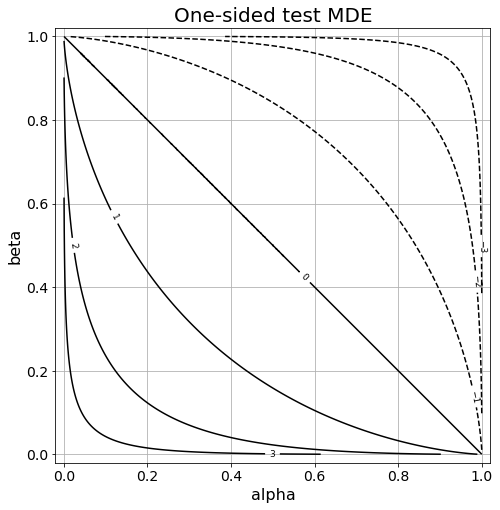

In [7]:
step = 0.0005
dist = stats.norm(loc=0, scale=1)
x = np.arange(0, 1, step)
y = np.arange(0, 1, step)
X, Y = np.meshgrid(x, y)
MDE = dist.ppf(1 - X) + dist.ppf(1 - Y)

fig, ax = plt.subplots(figsize=(8, 8))
CS = ax.contour(X, Y, MDE, levels=np.arange(-3, 4), colors='k')
ax.clabel(CS, fontsize=9, inline=True)
ax.set_title('One-sided test MDE')
ax.set_aspect('equal')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.grid()
fig.savefig('one_sided_mde.png')

**Вывод из этого графика:**  
Чем меньше ошибки мы позволяем себе допускать, тем больше нужен эффект, чтобы его стат.значимо обнаружить.  
При уменьшении заданных ошибок 1-го и 2-го рода MDE стремится в нижний левый угол, т.е. к +бесконечности

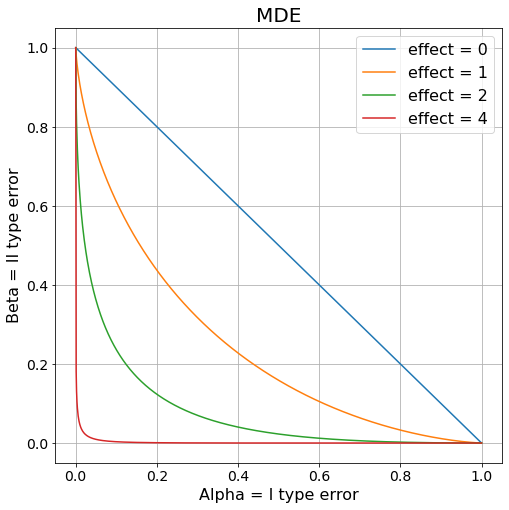

In [8]:
# Другой вариант этого же графика
alphas = np.linspace(0, 1, 1001)
plt.figure(figsize=(8, 8))
for effect in [0, 1, 2, 4]:
    plt.plot(alphas,
        get_beta(alpha=alphas, pilot_effect=effect, pilot_std=1, two_side=False),
        label=f"{effect = }")
plt.title('MDE')
plt.xlabel('Alpha = I type error')
plt.ylabel('Beta = II type error')
plt.legend()
plt.grid()

Еще раз формула для расчета размера выборки:

<font size=5>
$
n > \frac{[\Phi^{-1}(1 - \alpha) + \Phi^{-1}(1 - \beta)]^{2}(\sigma^{2}_{x} + \sigma^{2}_{y})}{\varepsilon^{2}}
$
</font>  

In [9]:
# Реализуем формулу для равных дисперсий
def min_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    ppf_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    ppf_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    n = ((ppf_alpha + ppf_beta) ** 2 * 2 * std ** 2) / epsilon ** 2
    return int(np.ceil(n))

In [10]:
# Сделаем спец. функцию для относительных эффектов
def min_sample_size_rel(mu, std, effect, alpha=0.05, beta=0.2):
    epsilon = (effect - 1) * mu
    return min_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

In [11]:
# Проверка t-тестом
def check_t_test(a, b, alpha=0.05):
    _, pval = stats.ttest_ind(a, b, equal_var=False)
    significant = 1 if pval < alpha else 0
    return significant

In [12]:
mu = 10
std = 1
effect = 1.01
alpha = 0.05
beta = 0.2

sample_size = min_sample_size_rel(mu, std, effect, alpha, beta)
print(f"{sample_size = }")

print('Type I and II errors:')
for _ in range(10):
    aa_errors,  ab_errors = [], []
    for _ in range (10_000):
        a1 = np.random.normal(loc=mu, scale=std, size=sample_size)
        a2 = np.random.normal(loc=mu, scale=std, size=sample_size)
        b = np.random.normal(loc=mu*effect, scale=std, size=sample_size)
        aa_errors.append(check_t_test(a1, a2, alpha=alpha))
        ab_errors.append(check_t_test(a1, b, alpha=alpha))
    print(f"{np.mean(aa_errors):.3f}\t{1 - np.mean(ab_errors):.3f}")

sample_size = 1570
Type I and II errors:
0.051	0.198
0.052	0.201
0.048	0.192
0.051	0.199
0.053	0.192
0.050	0.201
0.049	0.194
0.052	0.202
0.046	0.201
0.052	0.199


Размер ошибок соответствует ожиданиям, значит функции определения минимального размера выборки работают корректно

## Цена ошибки

Ожидаемый эффект обычно нельзя определить точно.  
Что будет, если мы получили эффект, который отличается от ожидаемого?



sample_size = 252


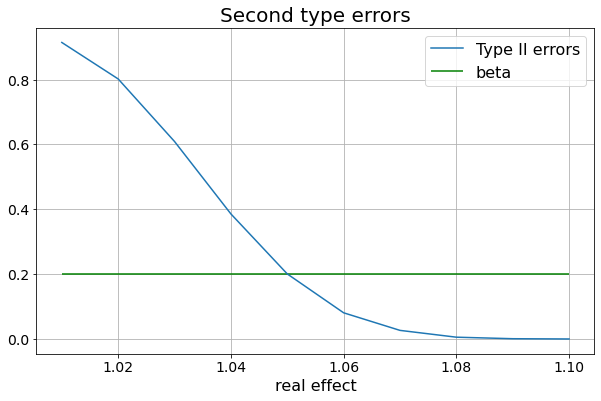

In [13]:
mu = 10
std = 2
effect = 1.05
alpha = 0.05
beta = 0.2

sample_size = min_sample_size_rel(mu, std, effect, alpha, beta)
print(f"{sample_size = }")

real_effects = np.arange(1.01, 1.1, 0.01)

second_type_errors = []
for real_effect in real_effects:
    ab_result = []
    for _ in range(10_000):
        a = np.random.normal(loc=mu, scale=std, size=sample_size)
        b = np.random.normal(loc=mu*real_effect, scale=std, size=sample_size)
        ab_result.append(check_t_test(a, b))
    second_type_errors.append(1 - np.mean(ab_result))
    
plt.figure(figsize=(10, 6))
plt.plot(real_effects, second_type_errors, label='Type II errors')
plt.title('Second type errors')
plt.hlines(0.2, 1.01, 1.1, label='beta', color='g')
plt.xlabel('real effect')
plt.legend()
plt.grid()

Если вместо ожидаемого эффекта в 5% реальный эффект будет 4%, то веротяность совершить ошибку 2-го рода вырастает в 2 раза: с 20% до 40%.  
Поэтому желательно брать выборку не минимального размера, а с запасом.

## Построим таблицу минимальных размеров выборок для различных эффектов и различных размеров ошибок

In [14]:
def get_table_min_sample_size(mu, std, effects, errors):
    sample_sizes = []
    for effect in effects:
        for error in errors:
            sample_size = min_sample_size_rel(mu, std, effect, alpha=error, beta=error)
            sample_sizes.append(sample_size)
            
    df = pd.DataFrame(np.array_split(sample_sizes, len(effects)))
    df.columns = errors
    df = df.rename_axis('Размер ошибки', axis=1)
    df.index = [str(int((eff - 1) * 100)) + '%' for eff in effects]
    df.index.name = 'Эффект'
    return df

In [15]:
effects = np.linspace(1.01, 1.1, 10)
errors = [0.05, 0.1, 0.15, 0.2]

get_table_min_sample_size(mu=10, std=2, effects=effects, errors=errors)

Размер ошибки,0.05,0.10,0.15,0.20
Эффект,,,,
1%,10396,6852,4905,3607
2%,2599,1713,1227,902
3%,1156,762,545,401
4%,650,429,307,226
5%,416,275,197,145
6%,289,191,137,101
7%,213,140,101,74
8%,163,108,77,57
9%,129,85,61,45


# MDE

In [17]:
# Загружаем датасет
URL_BASE = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'
data = pd.read_csv(URL_BASE + 'sem22_mde.csv')
print(data.shape)
data.head()

(432, 2)


,a,b
0,3.309855,3.215963
1,3.941470,3.633339
2,3.625108,3.530082
3,3.669770,3.380595
4,3.576930,3.247619


In [21]:
# Оценим стат. значимость различий в колонках
stats.ttest_ind(data['a'], data['b'], equal_var=False)

Ttest_indResult(statistic=1.8918383531968272, pvalue=0.05884757283725869)

Видим, что различия не стат.значимы

In [22]:
# Размер эффекта
epsilon = data['a'].mean() - data['b'].mean()
epsilon

0.17655833638856766

Еще раз посмотрим на формулу для расчета размера выборки (двустороннюю!):

<font size=5>
$
n > \frac{[\Phi^{-1}(1 - \frac{\alpha}{2}) + \Phi^{-1}(1 - \beta)]^{2}(\sigma^{2}_{x} + \sigma^{2}_{y})}{\varepsilon^{2}}
$
</font>  

Для нахождения MDE она примет вид:  
<font size=5>
$
\varepsilon > [\Phi^{-1}(1 - \frac{\alpha}{2}) + \Phi^{-1}(1 - \beta)] \sigma \sqrt{\frac{2}{n}}
$
</font>  

In [35]:
def get_minimum_detectable_effect(std, sample_size, alpha=0.05, beta=0.2):
    mde = (stats.norm.ppf(1 - alpha / 2) + stats.norm.ppf(1 - beta)) * std * (2 / sample_size) ** 0.5
    return mde

In [36]:
mde = get_minimum_detectable_effect(std=data['a'].std(), sample_size=len(data['a']), alpha=0.05, beta=0.2)
mde

0.26377591169191666

In [37]:
print(f"{epsilon = }")
print(f"{mde = }")

epsilon = 0.17655833638856766
mde = 0.26377591169191666


Видим, что реальный эффект меньше mde.  
Не удивительно, что стат.значимость не зафиксирована

## Попробуем снизить дисперсию, чтобы снизить mde и зафиксировать стат.значимость

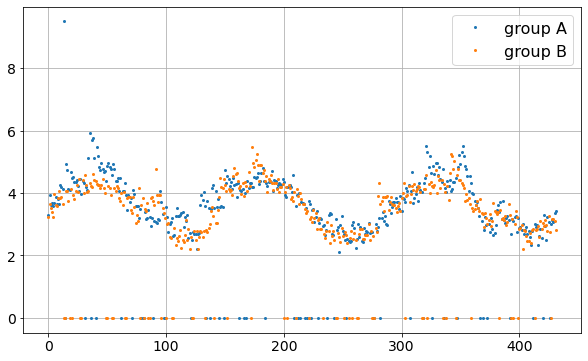

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(data['a'], 'o', markersize=2, label='group A')
plt.plot(data['b'], 'o', markersize=2, label='group B')
plt.legend()
plt.grid()

Видим нулевые значения. Вероятно, это пропуски в данных. Попробуем от них избавиться.

In [48]:
a_filtered = data[data['a'] > 0]['a']
b_filtered = data[data['b'] > 0]['b']

stats.ttest_ind(a_filtered, b_filtered, equal_var=False)

Ttest_indResult(statistic=2.2557582689099087, pvalue=0.024373789710192276)

Есть стат.значимость!

In [51]:
# Смотим, что еще изменилось после фильтрации
epsilon_2 = a_filtered.mean() - b_filtered.mean()
print(f"Эффект был: {epsilon:.3f}, стал: {epsilon_2:.3f}")
print(f"СКО А было: {data['a'].std():.3f}, стало: {a_filtered.std():.3f}")
print(f"СКО B было: {data['b'].std():.3f}, стало: {b_filtered.std():.3f}")

Эффект был: 0.177, стал: 0.123
СКО А было: 1.384, стало: 0.809
СКО B было: 1.359, стало: 0.691


Кстати, заметим, что СКО А и B после фильтрации стали сильно отличаться.  
Возможно, наши формулы теперь не совсем корректны, т.к. в них считается, что СКО одинаковые

In [52]:
# MDE после фильтрации для группы А
get_minimum_detectable_effect(std=a_filtered.std(), sample_size=len(a_filtered), alpha=0.05, beta=0.2)

0.16320276084166488

In [53]:
# MDE после фильтрации для группы B
get_minimum_detectable_effect(std=b_filtered.std(), sample_size=len(b_filtered), alpha=0.05, beta=0.2)

0.1408879170895415

Обратим внимание, что в обоих случаях MDE меньше, чем реальный эффект, который стат.значимо зафикисровался.  
Лектор сказал, что такое бывает (без объяснений).  
Но почему?